In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import AalenAdditiveFitter
import patsy
import emoji



%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [5]:
ses_full = pd.read_csv("../data/ses_full.csv")
ses_1_42 = pd.read_csv("../data/ses_1_42.csv")

ses

# Exploratory Data Analysis: Session, Message and Student Data

## Session

TypeError: cannot concatenate 'str' and 'float' objects

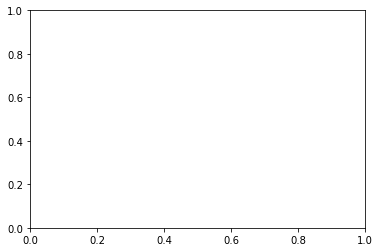

In [6]:
plt.hist(ses_1_42.timestamp_clean.values, bins =13)
plt.xlabel('Month')
plt.ylabel('# of Sessions')

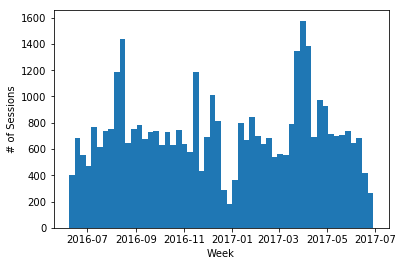

In [15]:
plt.hist(ses_1_42.timestamp_clean.values, bins = 54)
plt.xlabel('Week')
plt.ylabel('# of Sessions')

* Two Largest peaks in number of sessions are the begining and end of the 2016-2017 school year.
* The lowest point is in December.
* Looking at number of sessions by week below, there are some isolated drops around thanksgiving and Christmas.

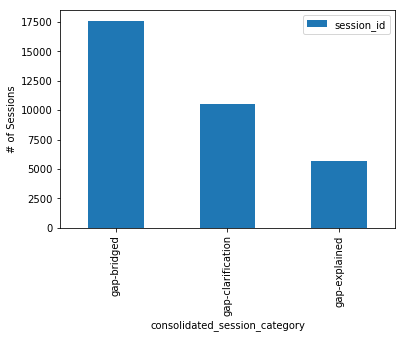

In [65]:
## Learning outcomes
learning_outcome_counts = pd.DataFrame(ses_1_42.groupby('consolidated_session_category').count()['session_id'])
learning_outcome_counts.plot(kind='bar')
plt.ylabel('# of Sessions')






* We see that the majority class, ~45% of graded sessions, is "gap-bridged"(the successful learning outcome). "gap-explained"(moderate success) and "gap-clarification"(minimal success)
* This means our overall learning success rate of 52%

In [5]:
monthly_all = pd.DataFrame(ses_1_42.groupby('year-month').count()['session_id']).reset_index()
monthly_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('year-month').count()['session_id']).reset_index()
monthly_all = monthly_all.merge(monthly_gb, on = 'year-month')
monthly_all['gb_rate'] = 1.0* monthly_all.session_id_y /monthly_all.session_id_x 
monthly_all = monthly_all.set_index('year-month')

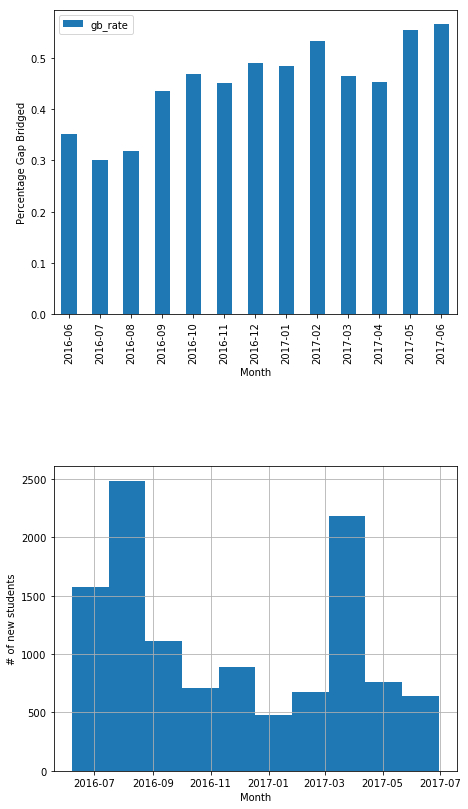

In [14]:
fig = plt.figure(figsize= (8,14))

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

monthly_all.drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar', ax = ax1)
ax1.set_xlabel('Month')
ax1.set_ylabel('Percentage Gap Bridged')


students.first_session.hist( ax = ax2)
ax2.set_xlabel('Month')
ax2.set_ylabel('# of new students')

plt.subplots_adjust(hspace=0.5, left=0.2)

* We see a matching effect with new students and drops in gb rate, particularily in August.
    * This suggests some type of interaction between time since first session and gap bridged student performance

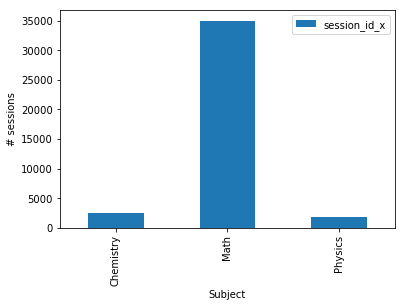

In [134]:
subject_all = pd.DataFrame(ses_1_42.groupby('subject').count()['session_id']).reset_index()
subject_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('subject').count()['session_id']).reset_index()
subject_all = subject_all.merge(subject_gb, on = 'subject')
subject_all['gb_rate'] = 1.0* subject_all.session_id_y /subject_all.session_id_x 

subject_all.set_index('subject').drop(['gb_rate', 'session_id_y'], axis = 1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('# sessions')

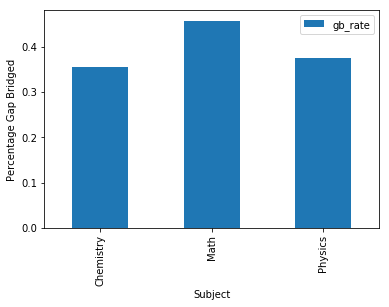

In [126]:
subject_all.set_index('subject').drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('Percentage Gap Bridged')

* ~88% Math sessions
* Math has a gap bridged rate 10% higher than Chemistry and 8% higher than Physics.

In [148]:
subject_all

,subject,session_id_x,session_id_y,gb_rate
0,Chemistry,2493,888,0.356197
1,Math,34989,16004,0.457401
2,Physics,1880,705,0.375000


In [131]:
subtopic_all = pd.DataFrame(ses_1_42.groupby('subtopic').count()['session_id']).reset_index()
subtopic_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('subtopic').count()['session_id']).reset_index()
subtopic_all = subtopic_all.merge(subtopic_gb, on = 'subtopic')
subtopic_all['gb_rate'] = 1.0* subtopic_all.session_id_y /subtopic_all.session_id_x 

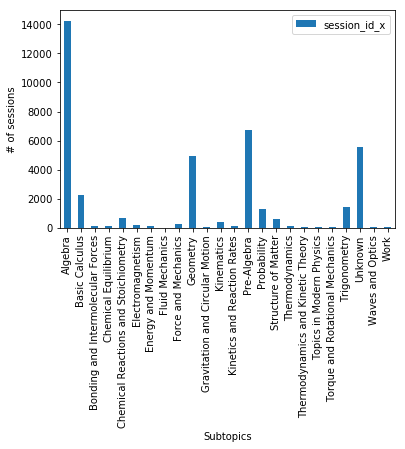

In [137]:
subtopic_all.set_index('subtopic').drop(['session_id_y', 'gb_rate'], axis = 1).plot(kind='bar')
plt.xlabel('Subtopics')
plt.ylabel('# of sessions')

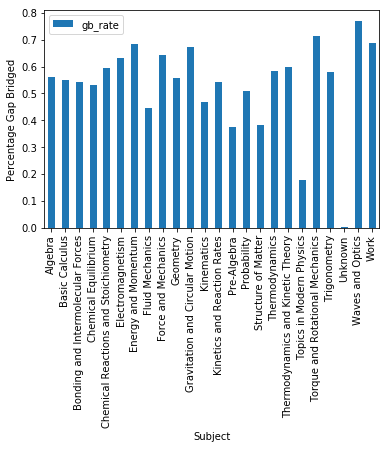

In [133]:
subtopic_all.set_index('subtopic').drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('Percentage Gap Bridged')

* Much like subject, subtopic is heavily weighted towards Math related areas of the study
* The clear top 3 are Algebra, Pre-Algebra and Geometry.
* Interestingly Pre-Algebra has a gap bridged rate 19% less than Alegebra, 56% versus 37% respectively.
    * Possible indication of a steep learning curve. 

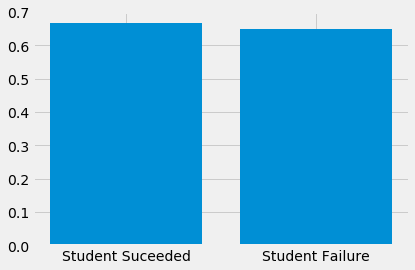

In [27]:
sc_by_gb_bool = [1 - ses_full[ses_full.gb_bool == 1].student_complained.mean(), 1 - ses_full[ses_full.gb_bool == 0].student_complained.mean()]
sc_labels = [0, 1]#
ses_full['cnt'] = 1
plt.style.use('fivethirtyeight')

plt.bar(pd.Series(sc_labels), pd.Series(sc_by_gb_bool) )
plt.xticks([0, 1], ('Student Suceeded', 'Student Failure'))

In [143]:
student_platform_all = pd.DataFrame(ses_1_42.groupby('student_platform').count()['session_id']).reset_index()
student_platform_gb = pd.DataFrame(ses_1_42[ses_1_42.consolidated_session_category == "gap-bridged"].groupby('student_platform').count()['session_id']).reset_index()
student_platform_all = student_platform_all.merge(student_platform_gb, on = 'student_platform')
student_platform_all['gb_rate'] = 1.0* student_platform_all.session_id_y /student_platform_all.session_id_x 

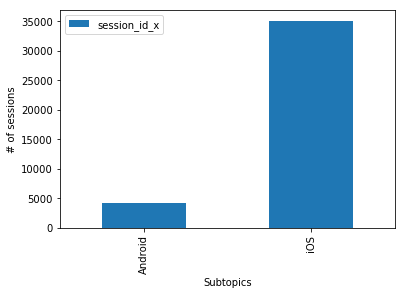

In [144]:
student_platform_all.set_index('student_platform').drop(['session_id_y', 'gb_rate'], axis = 1).plot(kind='bar')
plt.xlabel('platform')
plt.ylabel('# of sessions')

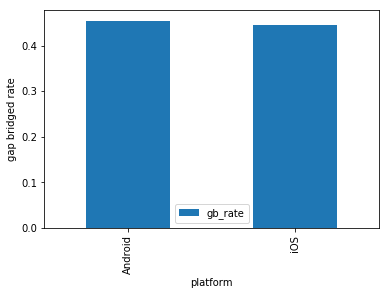

In [146]:
student_platform_all.set_index('student_platform').drop(['session_id_y', 'session_id_x'], axis = 1).plot(kind='bar')
plt.xlabel('platform')
plt.ylabel('gap bridged rate')

* ~88% iOS
* Only 0.8% difference in gap bridged rate

In [33]:
#Some mean comparison on gap bridged

new_cols = list(ses_full.columns[-7:])
for c in new_cols:
    print ses_full.groupby('gb_bool')[c].mean()

gb_bool
0.0    0.106619
1.0    0.351553
Name: how_y, dtype: float64
gb_bool
0.0    0.126188
1.0    0.397992
Name: what_y, dtype: float64
gb_bool
0.0    0.009222
1.0    0.043113
Name: when_y, dtype: float64
gb_bool
0.0    0.012428
1.0    0.050329
Name: where_y, dtype: float64
gb_bool
0.0    0.018276
1.0    0.089928
Name: why_y, dtype: float64
gb_bool
0.0    0.119215
1.0    0.329840
Name: can_y, dtype: float64
gb_bool
0.0    3.208345 
1.0    11.334045
Name: question_student_count, dtype: float64


In [59]:
ses_1_42[(pd.notnull(ses_1_42.length_of_session)) & (pd.notnull(ses_1_42.avg_tutor_response_time)) & (pd.notnull(ses_1_42.max_tutor_response_time))].describe().T

,count,mean,std,min,25%,50%,75%,max
session_id,33228,322191,12500.4,299889,311566,322512,332902,343367
tutor_id,33228,159749,167383,2,34864,54661,300294,531110
student_id,33228,421662,127141,52,385563,424178,522692,609630
feedback_score,33098,0.62312,0.458153,0,0,0.9,1,1
wait_time,33228,23.2164,88.37,1.36771,5.77364,8.16371,13.7699,3450.46
student_rating,30226,4.19751,1.53107,0,5,5,5,5
length_of_session,33228,-1.60058e+07,1.61202e+08,-1.49565e+09,429.996,1004.28,1970.74,1.48606e+09
avg_tutor_response_time,33228,32.5673,1036.87,0.00503778,14.2241,19.2501,26.2056,129541
max_tutor_response_time,33228,77.4936,1038.52,0.00503778,34.4697,53.4737,81.7549,129541
tutor_math_exam_score,27810,89.4899,10.6019,12,84,92,100,100


## Students

In [17]:
# New Transformations
ses_1_42 = ses_1_42.merge(students, on = 'student_id')
ses_1_42.loc[ses_1_42.consolidated_session_category == "gap-bridged", 'gb_bool'] = 1
ses_1_42.loc[ses_1_42.consolidated_session_category != "gap-bridged", 'gb_bool'] = 0
ses_1_42['days_since_ses_1'] = (ses_1_42.timestamp_clean - ses_1_42.first_session ).astype('timedelta64[D]')

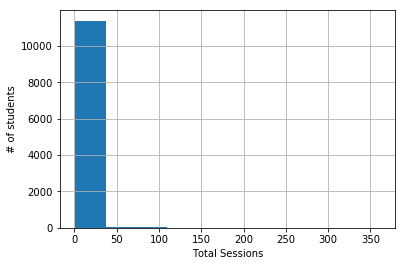

In [38]:

students.session_count.hist()
plt.xlabel("Total Sessions")
plt.ylabel("# of students")


* Almost all students have participated in less than 40 sessions.

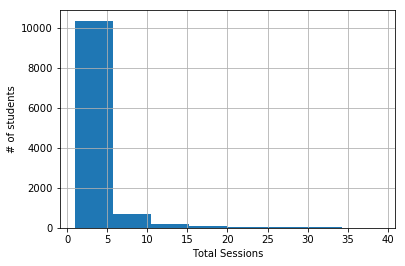

In [40]:

students[students.session_count< 40].session_count.hist(bins = 8)
plt.xlabel("Total Sessions")
plt.ylabel("# of students")

* Of these students with 40 or less sessions there remains a large cluster with 5 or less sessions.

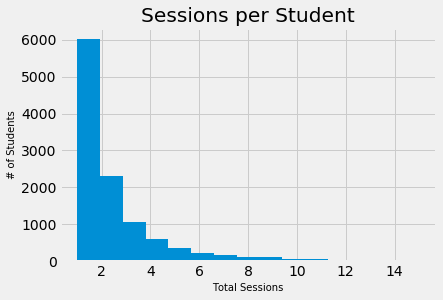

In [6]:
students = pd.read_csv("data/students.csv")
plt.style.use('fivethirtyeight')

students[(students.session_count<=15)].session_count.hist(bins = 15)
plt.xlabel("Total Sessions", size =10)
plt.ylabel("# of Students", size =10)
plt.title("Sessions per Student")

In [30]:
ses_full[pd.isnull(ses_full["tut_count_msg"])]

,Unnamed: 0,session_id,tutor_id,student_id,timestamp,feedback_score,wait_time,ended_by_reason,session_category,consolidated_session_category,...,crb_1,crb_2,crb_3,crb_4,crb_5,crb_6,crb_7,crb_8,crb_sum,first_name
325,325,300315,6.0,383437,2016-06-14 17:23:05 UTC,0.0,10.224090,student:end_button,gap-clarification,gap-clarification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Amber
433,433,300449,138032.0,383596,2016-06-15 14:44:19 UTC,0.0,3.668495,tutor:end_button,gap-clarification,gap-clarification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Junu
885,885,301089,42207.0,23993,2016-06-20 20:31:28 UTC,0.0,14.282846,student:end_button,gap-clarification,gap-clarification,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1642,1642,302141,NaN,385691,2016-06-30 16:42:22 UTC,NaN,250.694577,student:cancel_button,unclaimed,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Rashad
1643,1643,302142,NaN,385691,2016-06-30 16:47:12 UTC,NaN,3600.576103,server:timed_out,false,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Rashad
1669,1669,302190,5841.0,385755,2016-06-30 23:54:01 UTC,NaN,5.791799,student:cancel_button,false,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Valeria
1687,1687,302216,NaN,98716,2016-07-01 07:39:29 UTC,NaN,73.819331,student:cancel_button,unclaimed,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1688,1688,302218,NaN,385808,2016-07-01 13:08:25 UTC,NaN,80.052539,student:cancel_button,unclaimed,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Lokalokabuzz
1690,1690,302220,NaN,385809,2016-07-01 13:11:17 UTC,NaN,42.941116,student:terminated_app,false,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Bailey
1692,1692,302222,NaN,385819,2016-07-01 14:20:54 UTC,NaN,79.664812,student:cancel_button,unclaimed,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Lilmizz


In [32]:
ses_full.ses_time_delta

0        8.0  
1        43.0 
2        3.0  
3        20.0 
4        12.0 
5        57.0 
6        15.0 
7        52.0 
8        0.0  
9        41.0 
10       18.0 
11       6.0  
12       9.0  
13       3.0  
14       65.0 
15       166.0
16       77.0 
17       7.0  
18       4.0  
19       20.0 
20       40.0 
21       12.0 
22       47.0 
23       59.0 
24       36.0 
25       54.0 
26       26.0 
27       24.0 
28       115.0
29       6.0  
        ...   
36735    21.0 
36736    18.0 
36737    29.0 
36738    49.0 
36739    29.0 
36740    9.0  
36741    53.0 
36742    20.0 
36743    7.0  
36744    1.0  
36745    0.0  
36746    26.0 
36747    7.0  
36748    46.0 
36749    40.0 
36750    45.0 
36751    54.0 
36752    43.0 
36753    35.0 
36754    12.0 
36755    48.0 
36756    136.0
36757    9.0  
36758    8.0  
36759    82.0 
36760    49.0 
36761    28.0 
36762    13.0 
36763    12.0 
36764    2.0  
Name: ses_time_delta, dtype: float64

In [9]:
msg = pd.read_csv("data/msg.csv")
ses_full = pd.read_csv("data/ses_full.csv")

* Here's a view looking at students with at least 3 sessions, but less than 20. 
* I would classify these students as the useable population for the analysis. There are 2970 students in this subset.

In [1]:
ses_1_42.days_since_ses_1.hist(bins = 54)
plt.xlabel("Days since students first session")
plt.ylabel("# of sessions")



NameError: name 'ses_1_42' is not defined

* This shows that the vast majority of users do not use over  a long period of time most students will complete all their sessions within the space of a few days.

* Here's a comparison of mean for a selection of numerical variables grouped by 'gb_bool' (a boolean of whether gap-bridged was achieved or not.
    * wait_time(seconds) - gap bridged sessions have approx half the wait time as non-gap bridged.
    * len

In [58]:
ses_1_42[(pd.notnull(ses_1_42.length_of_session)) & (pd.notnull(ses_1_42.avg_tutor_response_time)) & (pd.notnull(ses_1_42.max_tutor_response_time))].groupby('gb_bool').mean()[['wait_time', 'length_of_session', 'student_complained','avg_tutor_response_time','max_tutor_response_time']].T





gb_bool,0.0,1.0
wait_time,2.206801e+01,2.424483e+01
length_of_session,-1.670071e+07,-1.538359e+07
student_complained,4.118359e-01,3.342841e-01
avg_tutor_response_time,3.773124e+01,2.794309e+01
max_tutor_response_time,7.148899e+01,8.287077e+01


In [59]:
#LOOK AT MAX MIN AND CREATE BETTTER VARIABLES WITH MESSAGE DATA
ses_1_42[(pd.notnull(ses_1_42.length_of_session)) & (pd.notnull(ses_1_42.avg_tutor_response_time)) & (pd.notnull(ses_1_42.max_tutor_response_time))].describe().T

,count,mean,std,min,25%,50%,75%,max
session_id,33228,322191,12500.4,299889,311566,322512,332902,343367
tutor_id,33228,159749,167383,2,34864,54661,300294,531110
student_id,33228,421662,127141,52,385563,424178,522692,609630
feedback_score,33098,0.62312,0.458153,0,0,0.9,1,1
wait_time,33228,23.2164,88.37,1.36771,5.77364,8.16371,13.7699,3450.46
student_rating,30226,4.19751,1.53107,0,5,5,5,5
length_of_session,33228,-1.60058e+07,1.61202e+08,-1.49565e+09,429.996,1004.28,1970.74,1.48606e+09
avg_tutor_response_time,33228,32.5673,1036.87,0.00503778,14.2241,19.2501,26.2056,129541
max_tutor_response_time,33228,77.4936,1038.52,0.00503778,34.4697,53.4737,81.7549,129541
tutor_math_exam_score,27810,89.4899,10.6019,12,84,92,100,100


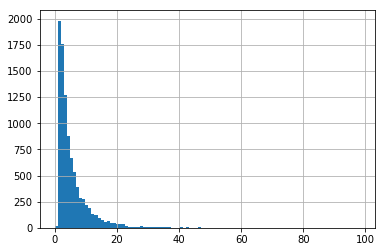

In [34]:
students_full.question_student_count_ratio.hist(bins=100)

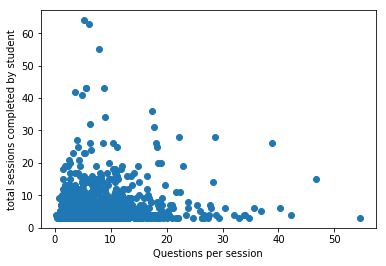

In [37]:
plt.scatter(students_full[students_full.session_count >2].question_student_count_ratio, students_full[students_full.session_count >2].session_count)
plt.xlabel('Questions per session')
plt.ylabel('total sessions completed by student')



mean questions per session over .5 gb rate
7.84197878656
mean questions per session below .5 gb rate
3.29603433612


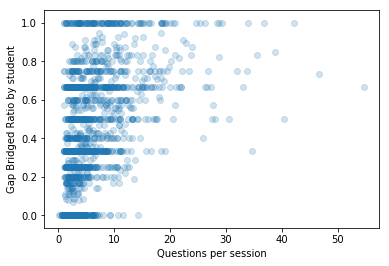

In [50]:
plt.scatter(students_full[students_full.session_count >2].question_student_count_ratio,\
            students_full[students_full.session_count >2].gb_rate\
           , alpha = 0.2)
plt.xlabel('Questions per session')
plt.ylabel('Gap Bridged Ratio by student')

print 'mean questions per session over .5 gb rate'
print students_full[students_full.gb_rate >= 0.5].question_student_count_ratio.mean()
print 'mean questions per session below .5 gb rate'
print students_full[students_full.gb_rate < 0.5].question_student_count_ratio.mean()

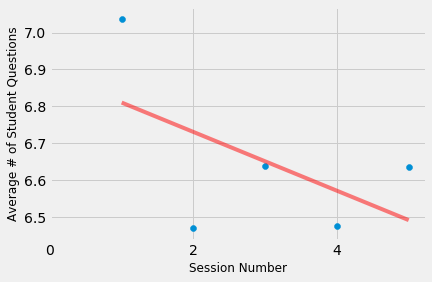

In [174]:
# Average number of questions
average_num_student_questions_by_session_number = ses_full[ses_full.session_count >=5].groupby('ses_num_order')['question_student_count'].mean()
x = average_num_student_questions_by_session_number.index[:5]
y = average_num_student_questions_by_session_number.values[:5]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
#pylab.plot(x,p(x),"r--")

plt.plot(x, p(x), alpha = 0.5, color = 'red', label = 'trend line')\
           #, c = gb_rate_by_session_number.values[:30])
plt.scatter(x, y, label = 'data points')
plt.xlabel('Session Number', size = 12)
plt.ylabel('Average # of Student Questions', size = 12)
plt.xticks(np.arange(min(x)-1, max(x)+1, 2.0))
#plt.legend(loc='lower right')
plt.style.use('fivethirtyeight')
plt.savefig('images/blogplot1.png', bbox_inches = 'tight')
##plt.colorbar()

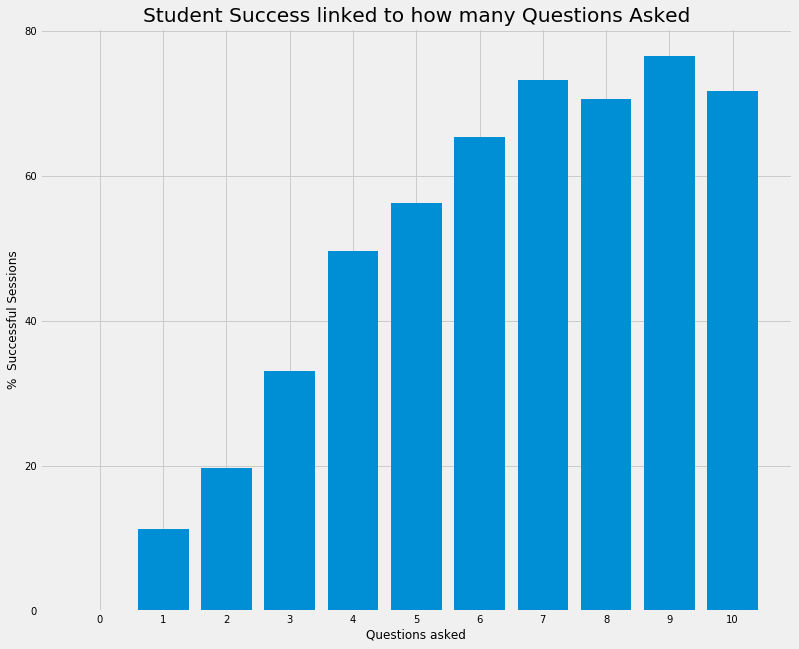

In [69]:
# gb rate per question asked
gb_rate_by_question_number = ses_full[ses_full.ses_num_order==1].groupby('question_student_count')['gb_bool'].mean()
avg_session_count_by_question_number = ses_full[ses_full.ses_num_order==1].groupby('question_student_count')['session_count'].mean()

x = gb_rate_by_question_number.index[:11]
y = [y*100 for y in gb_rate_by_question_number.values[:11]]
c = avg_session_count_by_question_number[:12]
plt.figure(figsize = (12,10))
plt.bar(x,y)
plt.title("Student Success linked to how many Questions Asked")
plt.ylabel('%  Successful Sessions', size = 12)
plt.xlabel('Questions asked', size = 12)
plt.xticks(np.arange(min(x), max(x)+1, 1.0), size = 10)
plt.yticks(np.arange(0, 100, 20), size = 10)
plt.style.use('fivethirtyeight')

plt.savefig('images/blogplot1.png', bbox_inches = 'tight')

#% Gap Bridge * Number of questions
# Looking at first session
# Account for dependency

# Read Paper

# Learning more

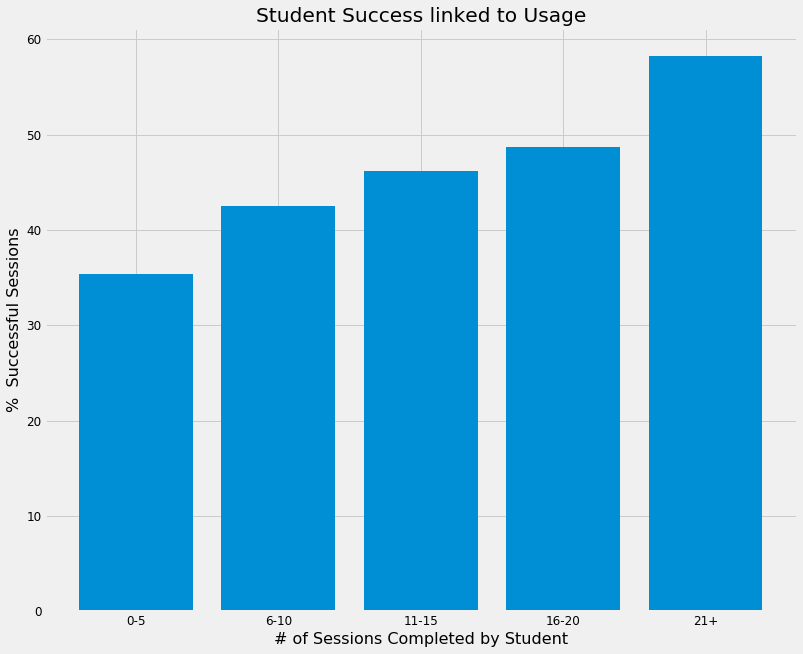

In [80]:
gb_rate_by_ses_count =  students.groupby("five_thres")['gb_count'].sum() / students.groupby("five_thres")['counter'].sum() 
x = gb_rate_by_ses_count.index
y = gb_rate_by_ses_count.values *100
plt.figure(figsize = (12,10))
plt.bar(x,y)
plt.title("Student Success linked to Usage")
plt.xlabel('# of Sessions Completed by Student', size = 16)
plt.ylabel('%  Successful Sessions', size = 16)
plt.xticks(np.arange(1,6,1),, size = 12)
plt.yticks( size = 12)
plt.style.use('fivethirtyeight')

plt.savefig('images/blogplot2.png', bbox_inches = 'tight')

In [83]:
ses[(ses.length_of_session > 0) & (ses.length_of_session < 724944)].length_of_session.mean()

1388.6805844663916

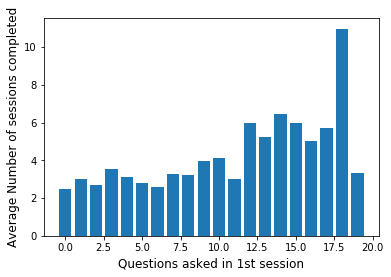

In [5]:
# gb rate per question asked
avg_session_count_by_question_number = ses_full[ses_full.ses_num_order==1 ].groupby('question_student_count')['session_count'].mean()

x = avg_session_count_by_question_number.index[:20]
y = avg_session_count_by_question_number.values[:20]
c = avg_session_count_by_question_number[:20]
plt.bar(x,y)
plt.xlabel('Questions asked in 1st session', size = 12)
plt.ylabel('Average Number of sessions completed', size = 12)
#plt.savefig('images/blogplot2.png', bbox_inches = 'tight')

#% Gap Bridge * Number of questions
# Looking at first session
# Account for dependency

# Read Paper
# Learning more

In [185]:
#Looking at lifetime learning rates for those that show a less curious behavior on session 1

print ses_full[(ses_full.ses_num_order==1 )& (ses_full.question_student_count<5)].gb_count.sum() / ses_full[(ses_full.ses_num_order==1 )& (ses_full.question_student_count<5)].session_count.sum()

ses_full[(ses_full.ses_num_order==1 )& (ses_full.question_student_count>=5)].gb_count.sum() / ses_full[(ses_full.ses_num_order==1 )& (ses_full.question_student_count>=5)].session_count.sum()



0.33380097269


0.6150375939849624

In [77]:
tholds = [0,5,10,15,20,25]
students.loc[(students.session_count > -1) & (students.session_count <= 5), "five_thres"] = 1
students.loc[(students.session_count > 5) & (students.session_count <= 10), "five_thres"] = 2
students.loc[(students.session_count > 10) & (students.session_count <= 15), "five_thres"] = 3
students.loc[(students.session_count > 15) & (students.session_count <= 20), "five_thres"] = 4
students.loc[(students.session_count > 20), "five_thres"] = 5


In [70]:
for i in range (10):
    print ses_full[(ses_full.question_student_count == i) & (ses_full.ses_num_order== 1)].shape

(5, 86)
(2602, 86)
(2076, 86)
(1363, 86)
(907, 86)
(640, 86)
(497, 86)
(384, 86)
(313, 86)
(303, 86)


In [138]:
average_word_count_by_session_number / average_num_student_questions_by_session_number 

ses_num_order
1      66.995578 
2      64.167023 
3      60.182751 
4      61.024136 
5      61.512233 
6      59.202628 
7      57.228490 
8      57.441222 
9      59.215852 
10     54.995654 
11     60.441002 
12     56.709715 
13     56.922763 
14     55.608095 
15     56.731741 
16     57.258622 
17     58.922290 
18     56.931910 
19     51.459650 
20     54.042712 
21     57.139233 
22     57.417018 
23     55.687059 
24     54.572443 
25     60.685813 
26     59.097492 
27     58.557772 
28     56.393113 
29     57.461154 
30     64.110357 
         ...     
295    45.454545 
296    64.090909 
297    54.172414 
298    60.187500 
299    66.750000 
300    49.241379 
301    46.757895 
302    43.444444 
303    36.135135 
304    41.500000 
305    45.142857 
306    41.000000 
307    5.500000  
308    4.000000  
309    24.666667 
310    15.666667 
311    26.666667 
312    18.000000 
313    34.000000 
314    21.346154 
315    19.750000 
316    52.571429 
317    47.636364 
318    10.0000

(0.014, 0.02)

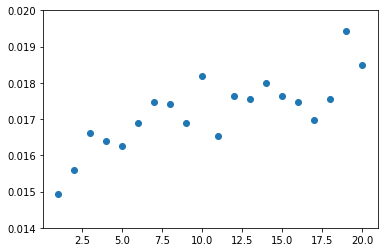

In [133]:
# questions per word
average_word_count_by_session_number = ses_full.groupby('ses_num_order')['word_count'].mean()
ques_over_words = average_num_student_questions_by_session_number / average_word_count_by_session_number
plt.scatter(ques_over_words.index[:20],ques_over_words.values[:20])
plt.ylim(0.014, 0.020)

* Over the first 20 sessions the number of questions asked by students doubles
* Over the same period learning sucees increases by 20 percentage points.
* We see parabolas in steps
    * Could this be a students giving up and leaving the smarter/suceesful students to continue

* There is chicken or the egg effect, does the student ask more questions and the sesssion goes longer, or does the session go longer and thus more questions are asked.
    * Working under the assumption that tutor behavior remains constant we can also assume that students are driving these longer sessions.
* Also we have the sampling issue of who is sampled. More unsuccessful students are sampled in the lower session numbers. 
    * Angle 1 (critical): students are smart going in and they continue to be smart and curious as they use the app.
    * Angle 2 (sympathetic): students are enabled by tutors to ask more questions and that curiousity is fostered by the app.


In [137]:
# Every X number of messages a question is asked.
ses_full.groupby('ses_num_order')['stu_count_msg'].mean() / average_num_student_questions_by_session_number

ses_num_order
1      4.385963 
2      4.387307 
3      4.186804 
4      4.281718 
5      4.241802 
6      4.187272 
7      4.083774 
8      4.163862 
9      4.149612 
10     4.061329 
11     4.130611 
12     3.967886 
13     4.070906 
14     3.858956 
15     4.000000 
16     4.251036 
17     4.173023 
18     4.078163 
19     3.887432 
20     3.904965 
21     3.960396 
22     4.114994 
23     4.013529 
24     3.940053 
25     4.321955 
26     4.068966 
27     4.098919 
28     4.225806 
29     4.112594 
30     4.403226 
         ...    
295    3.454545 
296    6.000000 
297    3.379310 
298    4.250000 
299    4.750000 
300    3.896552 
301    3.452632 
302    3.944444 
303    3.027027 
304    3.900000 
305    4.285714 
306    3.000000 
307    3.000000 
308    2.000000 
309    2.000000 
310    3.000000 
311    3.333333 
312    1.000000 
313    4.142857 
314    3.115385 
315    3.562500 
316    6.142857 
317    6.090909 
318    2.000000 
319    12.500000
320    6.040000 
321    3.800000 


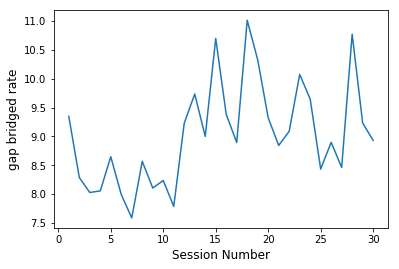

In [53]:
ses_full[ses_full['session_count'] >10].groupby('ses_num_order')['question_student_count'].mean()[:50]
x = ses_full[ses_full['session_count'] >10].groupby('ses_num_order')['question_student_count'].mean().index[:30]
y = ses_full[ses_full['session_count'] >10].groupby('ses_num_order')['question_student_count'].mean().values[:30]
plt.plot(x,y)
plt.xlabel('Session Number', size = 12)
plt.ylabel('gap bridged rate', size = 12)
plt.savefig('images/blogplot2.png', bbox_inches = 'tight')


In [46]:
avg_high_level_by_sesnum = ses_full.groupby('ses_num_order')['high_level'].mean()
avg_low_level_by_sesnum = ses_full.groupby('ses_num_order')['low_level'].mean()
avg_high_level_ratio_by_sesnum = ses_full.groupby('ses_num_order')['high_level_ratio'].mean()

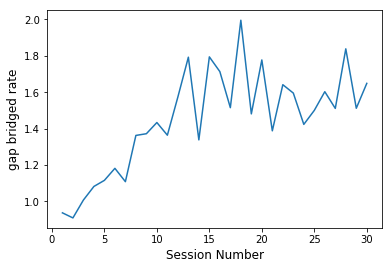

In [51]:

x = avg_high_level_by_sesnum.index[:30]
y = avg_high_level_by_sesnum.values[:30]
plt.plot(x,y)
plt.xlabel('Session Number', size = 12)
plt.ylabel('gap bridged rate', size = 12)

# Messages

In [73]:
#message processing, look closly at the following variables:
#[['wait_time', 'length_of_session', 'student_complained','avg_tutor_response_time','max_tutor_response_time']]

#Should be able to define these easily from message data without so many nans
msg.dtypes


session_id                object
created_at                object
sent_from                 object
sent_to                   object
content_type              object
text                      object
created_at_clean          object
text_readable             object
text_lower                object
how                       int64 
what                      int64 
when                      int64 
where                     int64 
why                       int64 
can                       int64 
question_student_count    int64 
first_word                object
dtype: object

In [96]:

# Student messages
# Tutor messages
# Word_count
# Question mark count
# Emoji Count
ses_1_42.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39369 entries, 0 to 39368
Data columns (total 80 columns):
session_id                          39369 non-null int64
tutor_id                            36157 non-null float64
student_id                          39369 non-null int64
timestamp                           39369 non-null object
feedback_score                      33836 non-null float64
wait_time                           39369 non-null float64
ended_by_reason                     39344 non-null object
session_category                    39366 non-null object
consolidated_session_category       33863 non-null object
student_complained                  39369 non-null bool
student_complaint_clarity           39369 non-null bool
student_complaint_speed             39369 non-null bool
student_complaint_subject           39369 non-null bool
student_complaint_other             39369 non-null bool
session_tag_cheating                39369 non-null bool
session_tag_inappropriate       

In [141]:
#aggrgates
ses_1_42['ques_per_msg'] = 1.0*ses_1_42.question_count / ses_1_42.total_count_msg
ses_1_42['words_per_msg'] = 1.0*ses_1_42.word_count / ses_1_42.total_count_msg
for word in ques_start:
    ses_1_42[word + str('_per_msg')] = 1.0*ses_1_42[word] / ses_1_42.total_count_msg

In [90]:
ses

In [106]:
miss_gb = ses_1_42[(pd.isnull(ses_1_42.word_count))& (ses_1_42.consolidated_session_category == 'gap-bridged')]['session_id']

In [160]:
ses_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34026 entries, 0 to 39368
Data columns (total 73 columns):
session_id                          34026 non-null int64
tutor_id                            32410 non-null float64
student_id                          34026 non-null int64
timestamp                           34026 non-null object
feedback_score                      30979 non-null float64
wait_time                           34026 non-null float64
ended_by_reason                     34001 non-null object
session_category                    34023 non-null object
consolidated_session_category       31006 non-null object
student_complained                  34026 non-null bool
student_complaint_clarity           34026 non-null bool
student_complaint_speed             34026 non-null bool
student_complaint_subject           34026 non-null bool
student_complaint_other             34026 non-null bool
session_tag_cheating                34026 non-null bool
session_tag_inappropriate       

In [98]:
msg.groupby('first_word')['session_id'].count().sort_values(ascending = False)[:20] #top 10 words

first_word
i         110429
yes       87704 
so        78212 
ok        64903 
what      56528 
no        51929 
can       47802 
we        41580 
do        38137 
that's    34243 
you       33706 
the       33651 
is        33378 
okay      32916 
how       32185 
so,       32115 
not       31524 
oh        30318 
great!    27422 
and       26466 
Name: session_id, dtype: int64

# Survey

In [82]:
# Still no survey join
ses_1_42.groupby('survey').mean()['gb_bool']

survey
0    0.447413
1    0.400545
Name: gb_bool, dtype: float64